In [94]:
from bs4 import BeautifulSoup
import re, pandas as pd
from selenium import webdriver
#import sys, os
import json
#import time
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
from pprint import pprint

In [95]:
def get_soup(url):
    """
    Given the url of a page, this function returns the soup object.
    
    Arguments:
    url -- the link to get soup object for
    
    Returns:
    soup - soup object
    """
    driver = webdriver.Firefox()
    driver.get(url)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    driver.close()
    
    return soup

In [96]:
def grab_job_links(soup):
    """
    Grab all non-sponsored job posting links from a Indeed search result page using the given soup object
    
    Arguments:
    soup -- the soup object corresponding to a search result page
            e.g. https://ca.indeed.com/jobs?q=data+scientist&l=Toronto&start=20
    
    Returns:
    urls -- a python list of job posting urls
    
    """
    urls = []
    
    # Loop thru all the posting links
    for link in soup.find_all('h2', {'class': 'jobtitle'}):
        # Since sponsored job postings are represented by "a target" instead of "a href", no need to worry here
        partial_url = link.a.get('href')
        # This is a partial url, we need to attach the prefix
        url = 'https://ca.indeed.com' + partial_url
        # Make sure this is not a sponsored posting
        urls.append(url)
    
    return urls

In [97]:
def get_urls(query, num_pages, location='Toronto'):
    """
    Get all the job posting URLs resulted from a specific search.
    
    Arguments:
    query -- job title to query
    num_pages -- number of pages needed
    location -- city to search in
    
    Returns:
    urls -- a list of job posting URL's
    """
    # We always need the first page
    base_url = 'https://ca.indeed.com/jobs?q={}&l={}'.format(query, location)
    soup = get_soup(base_url)
    urls = grab_job_links(soup)
    
    # Get the total number of postings found 
    posting_count_string = soup.find(name='div', attrs={'id':"searchCount"}).get_text()
    posting_count = int(s[s.find('of')+2:].strip())
    # Limit nunmber of pages to get
    max_pages = round(posting_count / 10) - 3
    if num_pages > max_pages:
        return max_pages
    
        # Additional work is needed when more than 1 page is requested
    if num_pages >= 2:
        # Start loop from page 2 since page 1 has been dealt with above
        for i in range(2, num_pages+1):
            num = (i-1) * 10
            base_url = 'https://ca.indeed.com/jobs?q={}&l={}&start={}'.format(query, location, num)
            soup = get_soup(base_url)
            # We always combine the results back to the list
            urls += grab_job_links(soup)

    # Check to ensure the number of urls gotten is correct
    assert len(urls) == num_pages * 10, "There are missing job links, check code!"

    return urls     

In [98]:
def get_posting(url):
    """
    Get the text portion of the job posting from the given url
    
    Arguments:
    url -- The job posting link
        
    Returns:
    title -- the job title (if "data scientist" is in the title)
    posting -- the job posting content    
    """
    # Get the url content as BS object
    soup = get_soup(url)
    
    # First check whether the title is Data Scientist - this info is held in the h3 tag
    try: # Avoid AttributeError when there's no title
        title = soup.find(name='h3').getText().lower()
        posting = soup.find(name='div', attrs={'class': "jobsearch-JobComponent"}).get_text()
        return title, posting.lower()
    
    except:
        return False
        
    #if 'data scientist' in title:  # We'll proceed to grab the job posting text if the title is correct
        # All the text info is contained in the div element with the below class, extract the text.
        #posting = soup.find(name='div', attrs={'class': "jobsearch-JobComponent"}).get_text()
        #return title, posting.lower()
    #else:
        #return False
    
        # Get rid of numbers and symbols other than given
        #text = re.sub("[^a-zA-Z'+#&]", " ", text)
        # Convert to lower case and split to list and then set
        #text = text.lower().strip()
    
        #return text

In [99]:
def get_all_postings(query, num_pages, location='Toronto'):
    """
    Run the search using given query and specified number of pages, store results in a dict.
    
    Arguments:
    query -- Indeed query keyword such as 'Data Scientist'
    num_pages - Number of search results needed
    location -- location to search for
    
    Returns:
    postings_dict -- Python dict including all posting data
    
    """
    
    postings_dict = {}
    urls = get_urls(query, num_pages, location)
    
    if isinstance(urls, list):
        num_urls = len(urls)
        counter = 0
        
        for url in urls:
            if get_posting(url):
                title, posting = get_posting(url)
                postings_dict[url] = {}
                postings_dict[url]['title'], postings_dict[url]['posting'] = title, posting
                counter += 1
                percent = counter / num_urls
                print("{:2.0f}%".format(100*percent))
            else:  # If the title doesn't contain 'data scientist', skip
                continue 

        return postings_dict

    print("Due to similar results, maximum number of pages is only {}. Please try again!".format(urls))

In [79]:
def plot_wc(text, max_words=200, stopwords_list=[]):
    """
    Make a word cloud plot using the given text.
    
    Arguments:
    text -- the text as a string
    
    Returns:
    None    
    """
    wordcloud = WordCloud().generate(text)
    stopwords = set(STOPWORDS)
    stopwords.update(stopwords_list)

    wordcloud = WordCloud(background_color='white',
                         stopwords=stopwords,
                         prefer_horizontal=1,
                         max_words=max_words, 
                         min_font_size=6,
                         scale=1,
                         width = 800, height = 800, 
                         random_state=8).generate(text)
    plt.figure(figsize=[16,16])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [100]:
data = get_all_postings('data+scientist', 50)

Due to similar results, maximum number of pages is only 32. Please try again!


In [ ]:
with open('postings.json', 'w') as f:
    json.dump(data, f)

In [7]:
with open('postings.json', 'r') as f:
    postings_dict = json.load(f)

In [87]:
[i['posting'] for i in data.values()]

['data scientist itd bank5,503 reviews-toronto, ontd bank5,503 reviewsread what people are saying about working here.tell us your story. don\'t go unnoticed. explain why you\'re a winning candidate. think "td" if you crave meaningful work and embrace change like we do. we are a trusted north american leader that cares about people and inspires them to grow and move forward.\nstay current and competitive. carve out a career for yourself. grow with us. here\'s our story: jobs.td.com\n\ndepartment overview td is on an exciting journey to become a data-driven organization with a goal to unlock $500mm in profit using data by 2021. the enterprise data and analytics (ed&a) organization is driving this transformation by bringing all of the bank\'s data into one central data lake and building the analytics platform of the future. the enterprise analytics team is the analytics consulting arm of the ed&a. the successful candidate will be a key part of the enterprise analytics team - a dynamic, in

In [84]:
len(data)

10

In [83]:
data.values()

dict_values([{'title': 'data scientist i', 'posting': 'data scientist itd bank5,503 reviews-toronto, ontd bank5,503 reviewsread what people are saying about working here.tell us your story. don\'t go unnoticed. explain why you\'re a winning candidate. think "td" if you crave meaningful work and embrace change like we do. we are a trusted north american leader that cares about people and inspires them to grow and move forward.\nstay current and competitive. carve out a career for yourself. grow with us. here\'s our story: jobs.td.com\n\ndepartment overview td is on an exciting journey to become a data-driven organization with a goal to unlock $500mm in profit using data by 2021. the enterprise data and analytics (ed&a) organization is driving this transformation by bringing all of the bank\'s data into one central data lake and building the analytics platform of the future. the enterprise analytics team is the analytics consulting arm of the ed&a. the successful candidate will be a key 

In [88]:
text = " ".join([i['posting'] for i in data.values()])

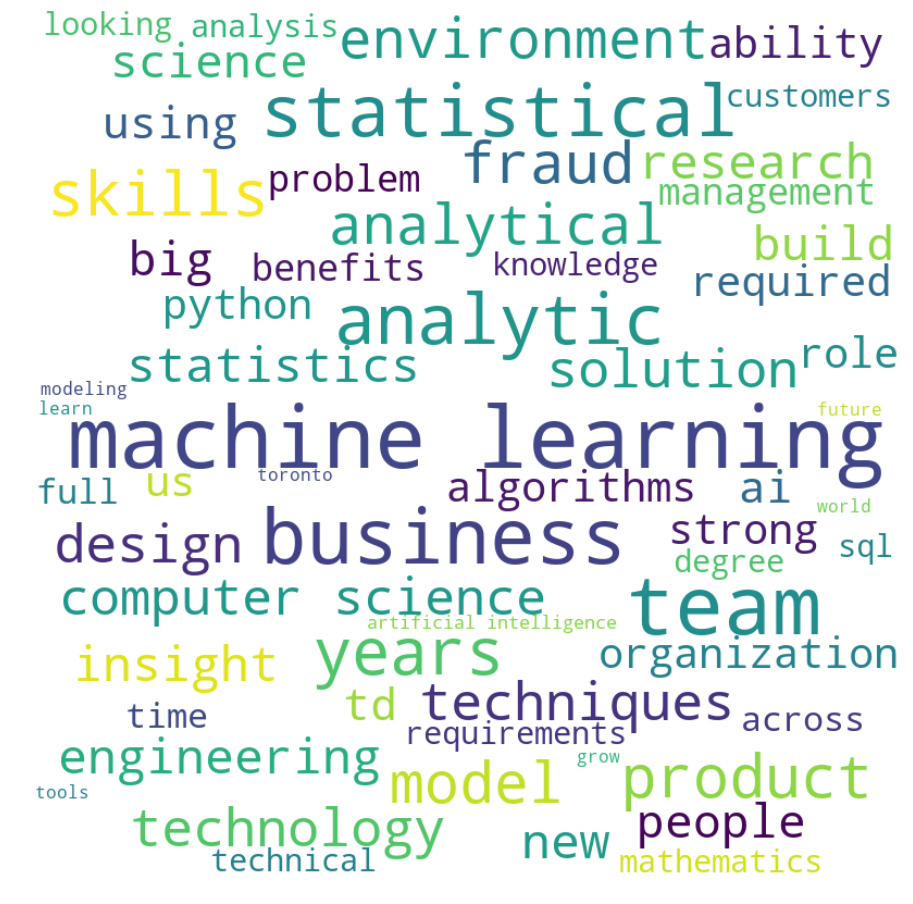

In [89]:
stopwords_list = ['ago', 'based', 'canada', 'candidate', 'company', 'data', 'days', 
                      'employee', 'ensure', 'et', 'etc', 'experience', 'help', 'including', 
                      'job', 'microsoft', 'nowapply', 'office', 'reviewsread', 'save', 'saying', 
                      'scientist', 'service', 'sitesave', 'skill', 'tool', 'understanding', 
                      'well', 'will', 'work', 'working', 'year', 'yearsjobapply']
plot_wc(text, max_words=60, stopwords_list=stopwords_list)

In [ ]:
def clean_text(text):
    """
    Clean the text so that all words are root...
    
    Arguments:
    
    Returns:
    Cleaned text
    
    """
    
    

## Todo's
- docstring and comments
- progress indicator
- one time per posting
- OOP
